# Convolutional Neural Networks

# Algorithm for a Dog Identification App 

In [1]:
import numpy as np
from glob import glob

In [3]:
!ls

sample_data


## Dowloading data

In [4]:

!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2019-04-30 17:49:58--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.28.29
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.28.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  31.3MB/s    in 35s     

2019-04-30 17:50:39 (31.1 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

--2019-04-30 17:50:41--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  78.1MB/s    in 2.2s    

2019-04-30 1

In [9]:
!unzip -qq dogImages.zip


replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!tar zxvf lfw.tgz

In [14]:
!ls

dogImages      haarcascade_frontalface_alt.xml	lfw.tgz
dogImages.zip  lfw				sample_data


In [16]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

Number of faces detected: 1


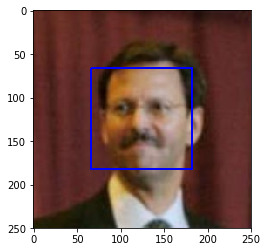

In [17]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

## Human Face Detector

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [0]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


f_count=0
d_count=0

for i in range(100):
    if face_detector(human_files_short[i]) == True:
        f_count += 1
    if face_detector(dog_files_short[i]) == True:
        d_count += 1


In [21]:
print("Percentage of human faces in human_files is: %d%% " %(f_count))  # 98
print("Percentage of human faces in dogs_files is: %d%%" %(d_count))    #17


Percentage of human faces in human_files is: 98% 
Percentage of human faces in dogs_files is: 9%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [22]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:31, 17338050.26it/s]


In [23]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Is GPU available: ', 'Yes' if torch.cuda.is_available() else 'No')
VGG16 = VGG16.to(device)

Is GPU available:  Yes


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In [0]:
from PIL import Image
import torchvision.transforms as transforms


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # used for truncated images. Becomes more tolerable


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    img = Image.open(img_path)
    
    
    transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])
    
    img = transform(img)
    
    img = img.to(device)
    
    img = img.unsqueeze(0)
    
    output = VGG16(img)
    
    output = output.data.argmax()
    
    
    return output # predicted class index

### Dog Detector

In [2]:
def dog_detector(img_path):
    pred_index = VGG16_predict(img_path)
    if pred_index > 150 and pred_index < 269:
        return True
    else:
        return False

In [47]:
human_files_short[0]

'lfw/Mark_Andrew/Mark_Andrew_0001.jpg'

In [48]:
h_count, d_count = 0, 0
for il, (human, dog) in enumerate(zip(human_files_short, dog_files_short)):
  if dog_detector(human):
    h_count += 1
  if dog_detector(dog):
    d_count += 1

print("Humans detected as dog: {}%".format(100. * float(h_count) / len(human_files_short)))
print("Dog Detection Accuracy: {}%".format(100. * float(d_count) / len(dog_files_short)))

print(dog_detector(human_files_short[1]))


Humans detected as dog: 1.0%
Dog Detection Accuracy: 100.0%
False


---
<a id='step3'></a>
## Step 3: CNN to Classify Dog Breeds (from Scratch)


### Data Loaders for the Dog Dataset

In [57]:
!ls dogImages

#The dirs for train, valid and train will be
train_dir = 'dogImages/train'
valid_dir = 'dogImages/valid'
test_dir = 'dogImages/test'

# !ls dogImages/test

test  train  valid


In [0]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [62]:

print('Num training images: ', len(loaders_scratch['train']))
print('Num validation images: ', len(loaders_scratch['valid']))
print('Num test images: ', len(loaders_scratch['test']))

Num training images:  334
Num validation images:  42
Num test images:  42


### Model Architecture

In [63]:
import torch.nn as nn
import torch.nn.functional as F


num_classes = 133 # total classes of dog breeds



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


### Loss Function and Optimizer

In [0]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### Train and Validate the Model

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    if last_validation_loss is not None:
        valid_loss_min = last_validation_loss
    else:
        valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            # calculate loss
            loss = criterion(output, target)
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [68]:
# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.770321 	Validation Loss: 4.592894
Validation loss decreased (inf --> 4.592894).  Saving model ...
Epoch: 2 	Training Loss: 4.632840 	Validation Loss: 4.557693
Validation loss decreased (4.592894 --> 4.557693).  Saving model ...
Epoch: 3 	Training Loss: 4.567807 	Validation Loss: 4.417354
Validation loss decreased (4.557693 --> 4.417354).  Saving model ...
Epoch: 4 	Training Loss: 4.518969 	Validation Loss: 4.330721
Validation loss decreased (4.417354 --> 4.330721).  Saving model ...
Epoch: 5 	Training Loss: 4.464338 	Validation Loss: 4.281645
Validation loss decreased (4.330721 --> 4.281645).  Saving model ...
Epoch: 6 	Training Loss: 4.379672 	Validation Loss: 4.379429
Epoch: 7 	Training Loss: 4.323409 	Validation Loss: 4.107655
Validation loss decreased (4.281645 --> 4.107655).  Saving model ...
Epoch: 8 	Training Loss: 4.271601 	Validation Loss: 4.047601
Validation loss decreased (4.107655 --> 4.047601).  Saving model ...
Epoch: 9 	Training Loss: 4.198718 

In [0]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Testing the Model

In [71]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.010440


Test Accuracy: 10% (87/836)


---
<a id='step4'></a>
## Step 4: CNN to Classify Dog Breeds (using Transfer Learning)

In [0]:
data_dir = 'dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# Batch size
batch_size = 64
# For faster computation, setting num_workers
num_workers = 4

# Transforms for the training, validation, and testing sets
data_transforms = {
    'train'      : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),

    'valid'      : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
    'test'       : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
}

# Loading the datasets with ImageFolder
image_datasets = {
    'train'  : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid'  : datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test'   : datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Using the image datasets and the trainforms in defining the dataloaders
dataloaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size = batch_size, shuffle=True, num_workers = num_workers),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size = batch_size),
    'test'  : torch.utils.data.DataLoader(image_datasets['test'], batch_size = batch_size)
}

### Model Architecture

In [79]:
import torchvision.models as models
import torch.nn as nn

# Loading the pretrained model
model_transfer = models.densenet161(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
115730790it [00:01, 76293627.12it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

### Loss Function and Optimizer

In [80]:
# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
    
in_features = model_transfer.classifier.in_features
hidden_layer = 1000
out_features = 133

# Creating a custom classifier and attaching to the model
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(in_features, hidden_layer)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=.25)),
                          ('fc2', nn.Linear(hidden_layer, out_features)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model_transfer.classifier = classifier
model_transfer.classifier

Sequential(
  (fc1): Linear(in_features=2208, out_features=1000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25)
  (fc2): Linear(in_features=1000, out_features=133, bias=True)
  (output): LogSoftmax()
)

In [81]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Is GPU available: ', 'Yes' if torch.cuda.is_available() else 'No')

Is GPU available:  Yes


In [0]:
# Selecting the loss function and optimizer
criterion_transfer = nn.NLLLoss()

optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.003)

# Moving the model to the device
model_transfer.to(device);

### Train and Validate the Model

In [83]:
loaders_transfer = dataloaders

# train the model
model_transfer = train(5, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 2.621995 	Validation Loss: 0.933110
Validation loss decreased (inf --> 0.933110).  Saving model ...
Epoch: 2 	Training Loss: 1.312294 	Validation Loss: 0.637803
Validation loss decreased (0.933110 --> 0.637803).  Saving model ...
Epoch: 3 	Training Loss: 1.134209 	Validation Loss: 0.438293
Validation loss decreased (0.637803 --> 0.438293).  Saving model ...
Epoch: 4 	Training Loss: 1.053036 	Validation Loss: 0.518481
Epoch: 5 	Training Loss: 1.048513 	Validation Loss: 0.417859
Validation loss decreased (0.438293 --> 0.417859).  Saving model ...


### Testing the Model

In [0]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [85]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.448163


Test Accuracy: 85% (712/836)


### Predicting Dog Breed with the Model

In [0]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    transform = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
    image_pil = Image.open(img_path)
    img_tensor = transform(image_pil)
    image = img_tensor.unsqueeze_(0)
    if use_cuda:
        image = image.cuda()
    prediction = model_transfer(image)
    
    breed_class = prediction.argmax()
    
    breed = class_names[breed_class]

    return breed

In [0]:
############  TESTING    #################

In [145]:
predict_breed_transfer("dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg")

'Afghan hound'

In [146]:
predict_breed_transfer("dogImages/test/004.Akita/Akita_00276.jpg")

'Akita'

---
<a id='step5'></a>
## An algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [0]:
from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    image = imread(img_path)
    plt.imshow(image)
    if dog_detector(img_path) == True:
        print("Dog detected!")
        breed = predict_breed_transfer(img_path)
        print("Breed is " + breed + ".")
    elif face_detector(img_path) == True:
        print("Hello, human!")
        breed = predict_breed_transfer(img_path)
        print("You resemble a " + breed + "!")
    else:
        print("I detect neither a dog nor a human in this image.")

Dog detected!
Breed is Afghan hound.


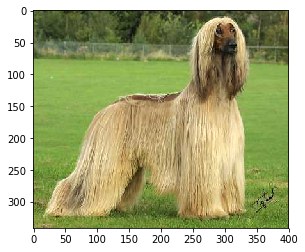

In [148]:
#Testing...
run_app("dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

1. Bigger datasets always prove to be helping. The model gets to learn from a wide range of images.
2. We can fine tune the hyper-parameters to again refine the model.
3. Shuffling the datasets.

Hello, human!
You resemble a French bulldog!


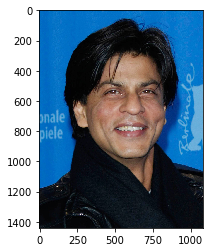

In [149]:
run_app('Shahrukh.jpg')

Dog detected!
Breed is American eskimo dog.


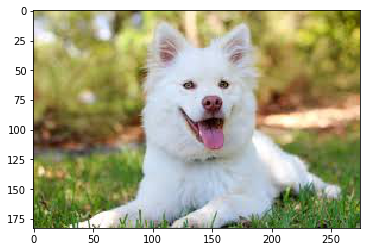

In [150]:
run_app('download2.jpg')

Dog detected!
Breed is Labrador retriever.


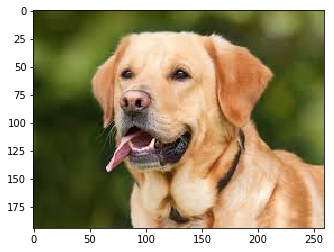

In [152]:
run_app('download3.jpg')

Dog detected!
Breed is Nova scotia duck tolling retriever.


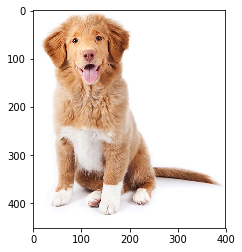

In [153]:
run_app('download4.jpg')

I detect neither a dog nor a human in this image.


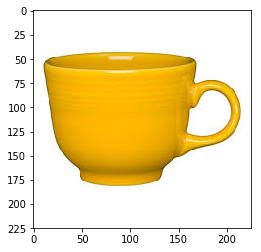

In [154]:
run_app('download5.jpg')

Hello, human!
You resemble a Cane corso!


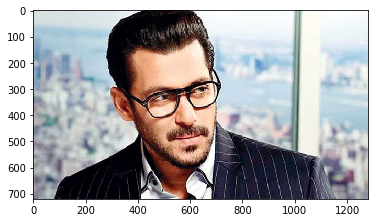

In [155]:
run_app('download6.jpg')